In [33]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
from functools import lru_cache
from typing import Sequence

np.set_printoptions(suppress=True)

In [3]:
# import
path = Path(kagglehub.dataset_download("mczielinski/bitcoin-historical-data"))/"btcusd_1-min_data.csv"
raw_records = pd.read_csv(
    path,
    usecols=["Open","High","Low","Close","Volume"]
)
first_datetime = datetime.fromisoformat(pd.read_csv(path,nrows=1).loc[0,"datetime"])

In [4]:
datetime_index = pd.date_range(
    start=first_datetime,
    freq=timedelta(minutes=1),
    periods=raw_records.index[-1]+1
)
records = raw_records
records.index = datetime_index
records.index.name = "datetime"
records.rename(columns=lambda col: col.lower(), inplace=True)
records.head()

,open,high,low,close,volume
datetime,,,,,
2012-01-01 10:01:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00+00:00,4.58,4.58,4.58,4.58,0.0


---
**If you held bitcoin for up to 30 days where would your profit lie?**

In [55]:
# calculate the profit
@lru_cache(maxsize=30, typed=False)
def profit_quantiles(MAX_SPAN_DAYS: int = 30, QUANTILES: Sequence[float|int] = (0.01,0.25,0.5,0.75,0.99)) -> pd.DataFrame:
    return_of_hold = pd.DataFrame({k:0.0 for k in QUANTILES},index=range(1,MAX_SPAN_DAYS+1))
    
    grouped = (records
               .groupby(records.index.date)
               .mean()["close"]
               .reset_index(drop=True)
              )
    
    for span in range(2,MAX_SPAN_DAYS+1):
        res = (grouped
               .rolling(window=span)
               .apply(lambda srs: (srs.iat[-1] / srs.iat[0] - 1) * 100)
               .quantile(QUANTILES)
              )
        #print(f"Span of {span} days calculated")
        return_of_hold.loc[span] = res
    return return_of_hold

In [59]:
MAX_SPAN_DAYS = 100
QUANTILES = (0.01,0.25,0.5,0.75,0.99)
return_of_hold = profit_quantiles(MAX_SPAN_DAYS=MAX_SPAN_DAYS, QUANTILES=QUANTILES)

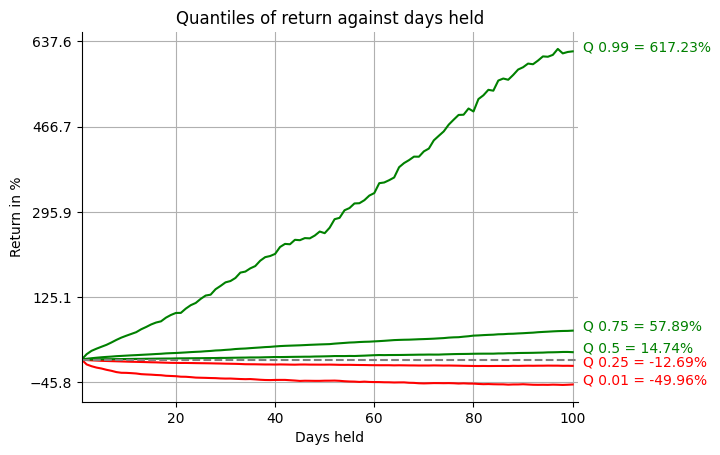

In [60]:
# charting
ax = plt.subplot()
for quantile, data in return_of_hold.items():
    if data.iat[-1] < 0:
        color = "red"
    elif data.iat[-1] == 0:
        color = "grey"
    else:
        color = "green"
        
    ax.plot(data,color=color)
    ax.text(x=MAX_SPAN_DAYS*1.02,y=data.iat[-1], s=f"Q {round(quantile,4)} = {round(data.iat[-1],2)}%", color=color)
    
ax.axhline(0,linestyle="dashed",color="grey")

ax.set_title("Quantiles of return against days held")
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Days held")
ax.set_xlim(1,MAX_SPAN_DAYS*1.01)

ax.set_yticks(
    np.arange(return_of_hold.min(axis=None)*0.9, return_of_hold.max(axis=None)*1.1, return_of_hold.mean(axis=None)*3).round(2)
)
ax.set_ylabel("Return in %");